In [11]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import pytorch_models
import imp
import torchaudio as ta
import torchaudio
import torchvision as tv
import matplotlib.pyplot as plt
from IPython.display import Audio
import os, random
import pandas as pd
import mir_utils as miru
from torch.utils.data import Dataset, DataLoader
from pytorch_models import *
import librosa
import librosa.display
import pytorch_models as pm
import optuna
imp.reload(miru)
imp.reload(pytorch_models)
SR=44100
#functions
spec=torchaudio.functional.spectrogram

audio_frames=miru.audioFrames(loadCache=True)

def getMeanLength(x):
    gl=x.apply(lambda z: len(z["audio"]),axis=1)
    print(gl.mean()/SR,gl.mean(),x["label"].iloc[0])
    
# audio_frames.groupby(by=["label_num"]).apply(lambda x:getMeanLength(x))
# getMeanLength(audio_frames)


def getRandAud():
    classes=os.listdir("./dk_data/")
    rand_class=random.choice(classes)
#     rand_class="synth_noise"
    rand_sample=random.choice(os.listdir("./dk_data/%s/"%(rand_class,)))
    return "./dk_data/"+rand_class+"/"+rand_sample
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# list(zip(uniques,range(0,len(uniques))))

audio_frames=audio_frames.loc[~audio_frames["label"].isin(["shake","guitar","piano"])]        
#split the dataframe into 2 seperate ones:
drum_frames=audio_frames.loc[~audio_frames["label"].isin(["synth_noise","guitar","piano"])]
#split the dataframe into 2 seperate ones:
not_drum_frames=audio_frames.loc[audio_frames["label"].isin(["synth_noise","guitar","piano"])]


In [12]:
#make two label series, one for drum vs not drum classification, one for drum type classification
#add the series to the dataframe 
# print(drum_labels,not_drum_labels)

#drum only classification
# audio_frames["label_num"].isin(not_drum_labels)
dLabels, dUniques=pd.factorize(drum_frames["label"].tolist())
ndLabels, ndUniques=pd.factorize(not_drum_frames["label"].tolist())

drum_frames["label_num"]=dLabels
not_drum_frames["label_num"]=ndLabels+len(dUniques)

allU=np.concatenate([dUniques,ndUniques])
lmap=list(zip(allU,range(len(allU))))

#get weights for each group
# x=drum_frames.groupby(["label"]).agg("count")["path"]
y=audio_frames.groupby(["label"]).agg("count")["path"]
print(y)
weights=torch.tensor([1000/w for w in y.tolist()])


/home/asalimi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/asalimi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


label
clap             118
hihat_closed     187
hihat_open       280
kick             648
rim              105
snare            731
synth_noise     6000
tom_high         179
tom_low          188
tom_mid          139
Name: path, dtype: int64


In [13]:
class audioDataset(torch.utils.data.Dataset):
    def __init__(self,audio_frame,root_dir, task="keep_all",transform=None):
        self.root_dir=root_dir
        self.task=task
        self.audio_frame=audio_frame
        self.transform = transform
        self.minLength=SR
#         self.minLength=SR//4
        self.frame_pruning()
    def __len__(self):
        return len(self.audio_frame)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        rows=self.audio_frame.iloc[idx]

        signals,labels=rows["audio"].tolist()[0:SR],rows["label_num"].tolist()
        signals,labels=torch.tensor(signals),torch.tensor(labels)
        
        nz=np.max((self.minLength-signals.shape[0],0))
        signals=torch.cat([signals[0:self.minLength],torch.zeros(nz)],dim=0)

        sound={"signal":signals,"label":labels,"path":rows["path"],"drum_type":rows["label"]}
        
        if self.transform:
            sound = self.transform(sound)

        return sound
    
    def frame_pruning(self):
        #drum vs not drum classification:
        drum_label_numbers=range(len(dUniques))
        if self.task=="dvn":
            self.audio_frame.loc[self.audio_frame["label_num"].isin(drum_label_numbers),"label_num"]=0
            self.audio_frame.loc[~self.audio_frame["label_num"].isin(drum_label_numbers),"label_num"]=1
        #drum type classification
        if self.task=="dvd":
            self.audio_frame=self.audio_frame.loc[self.audio_frame["label_num"].isin(drum_label_numbers)]
        if self.task=="keep_all":
            pass
            
ds=audioDataset(pd.concat([drum_frames,not_drum_frames]),"./",task="dvn",)
idx=np.random.randint(0,len(ds),5)
all_frames=pd.concat([drum_frames,not_drum_frames])
train=all_frames.sample(frac=0.80,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)
ds[0]

{'signal': tensor([-0.0003, -0.0019,  0.0305,  ...,  0.0000,  0.0000,  0.0000]),
 'label': tensor(0),
 'path': './dk_data/tom_high/Roland Tr-909-TR-909Tom Hi 01.wav',
 'drum_type': 'tom_high'}

torch.Size([1, 30, 20]) tensor([2.1059e-05, 1.9211e-04, 1.5416e-03, 1.4328e-03, 1.6815e-03, 2.3218e-03,
        2.2623e-03, 1.2743e-03, 2.3113e-03, 2.4826e-03, 2.3174e-03, 2.1267e-03,
        1.2683e-03, 8.2899e-04, 4.7286e-04, 5.3741e-04, 5.5563e-04, 4.8761e-04,
        8.0832e-04, 6.7958e-04, 9.2894e-04, 9.9240e-04, 8.4051e-04, 4.7562e-04,
        1.9162e-04, 6.1819e-05, 7.2237e-06, 1.5429e-06, 1.5496e-06, 1.6123e-06])
('tom_low', 1) tensor(1) 44100


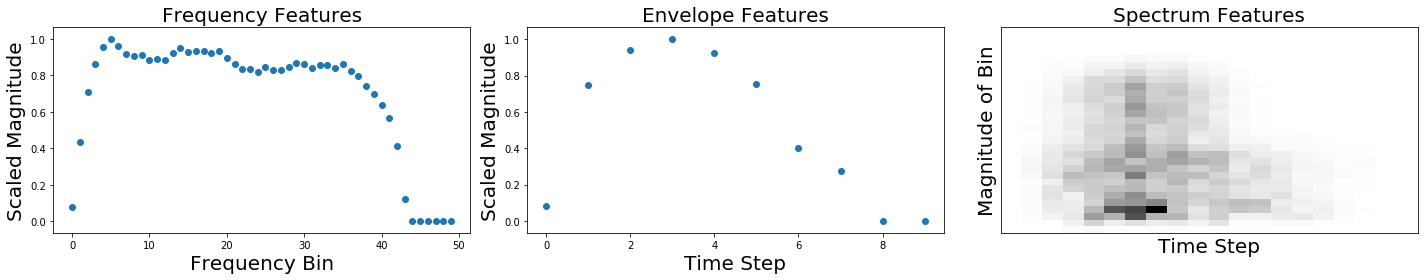

In [20]:
FREQ_BINS=30
TIME_STEPS=20
#defining transformations
class freqTrans(object):
    def __init__(self,num_mels=50,SR=SR):
        self.num_mels=num_mels
        self.ampT=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=30)
        self.melF=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
        
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR//4
        wf=wf[:,0:24000]
        num_bins=wf[0].shape[0]
        win_length=num_bins
        hop_step=sample_length//(self.num_mels)
        window=torch.tensor([1]*win_length)
        s=spec(wf, 100, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melF(s)
        s=self.ampT(s)
        freq=s.sum(axis=0).sum(axis=1)
        freq=freq-freq.min()
        freq=freq/freq.max()
        freq[torch.isnan(freq)]=0
        return {"feats":freq.detach(),"label":label}

class envTrans(object):
    def __init__(self,num_mels=10,SR=SR):
        self.env_size=9
        self.num_mels=num_mels
        self.amp=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=60)
        self.melEnv=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
#         self.norm= transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        
        wf=wf.reshape(-1,len(wf))
        sample_length=SR
        num_bins=wf[0].shape[0]
        win_length=SR//20
        hop_step=SR//self.env_size
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window,win_length, hop_step, win_length,2,normalized=False)
        s=self.melEnv(s)
        s=self.amp(s)
#         s=self.norm(s)
        #normalizing
        env=s.sum(axis=0).sum(axis=0)
        env=env-env.min()
        env=env/env.max()
        env[torch.isnan(env)]=0

        num_padding=torch.max(torch.tensor([self.env_size+1-env.shape[0],0]))
        env_vec=torch.cat([env.detach(),torch.zeros(num_padding)],dim=0)
        return {"feats":env_vec.detach(),"label":label}

class feats_and_env(object):
    def __init__(self,feat_mels=50,env_mels=1):
        self.ft=freqTrans(num_mels=feat_mels)
        self.et=envTrans(num_mels=env_mels)

    def __call__(self, sample):
            combined_feats=torch.cat((self.ft(sample)["feats"],self.et(sample)["feats"]))
            return {"feats":combined_feats,"label":sample["label"]}
        

class specTrans(object):
    def __init__(self,num_mels=50,SR=SR,time_steps=20):
        self.num_mels=num_mels
        self.ampP=torchaudio.transforms.AmplitudeToDB(stype='power',top_db=60)
        self.melP=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR,n_stft=None)
        self.norm= transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        self.hop_step=time_steps-1
    def __call__(self, sample):
        
        wf,label,p,drum_type=sample["signal"],sample["label"],sample["path"],sample["drum_type"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR

        num_bins=wf[0].shape[0]
        win_length=SR//17
        hop_step=SR//self.hop_step
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melP(s)
#         s=self.ampP(s)
        s = s - s.min()
        s = s/s.abs().max()

        freq=s
#         freq=self.norm(s)
        freq[torch.isnan(freq)]=0
        return {"feats":freq.detach(),"label":label,"path":p,"drum_type":drum_type}

#Apply each of the above transforms on sample.
fig = plt.figure(figsize=(20,4))
# while True:
sample = ds[np.random.randint(len(ds))]
#     print(sample["label"].item())
#     if sample["label"].item()==1:
#         break
# freq_train = audioDataset(train,".",task="dvd")
# f_train_loader= DataLoader(freq_train, batch_size=16, num_workers=1)
# sample=iter(f_train_loader).next()
# s={"signal":sample["signal"][0],"label":sample["label"][0],"path":sample["path"],"drum_type":sample["drum_type"]}
# sample=s
tfList=[freqTrans(50),envTrans(num_mels=10,SR=SR),specTrans(FREQ_BINS,time_steps=TIME_STEPS)]

for i, tsfrm in enumerate(tfList):
    transformed_sample = tsfrm(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ft=transformed_sample["feats"]
    if i==0:
        plt.title("Frequency Features",fontsize=20)
        plt.xlabel("Frequency Bin",fontsize=20)
        plt.ylabel("Scaled Magnitude",fontsize=20)
                   
        plt.scatter(y=ft,x=range(0,len(ft)))
    if i==1:
        plt.title("Envelope Features",fontsize=20)
        plt.xlabel("Time Step",fontsize=20)
        plt.ylabel("Scaled Magnitude",fontsize=20)            
        plt.scatter(y=ft,x=range(0,len(ft)))
    if i==2:
        print(ft.shape,ft[0,:,0])
        sf=ft.detach().numpy()[0]
        ft=ft.detach().numpy()[0]
        plt.title("Spectrum Features",fontsize=20)
        librosa.display.specshow(sf,cmap='gray_r',)
        plt.xlabel("Time Step",fontsize=20)
        plt.ylabel("Magnitude of Bin",fontsize=20)

#         plt.savefig("./plots/ff3.pdf",bbox_inches = "tight")
# plt.show()
print(lmap[transformed_sample["label"].item()],transformed_sample["label"],len(sample["signal"]))


Audio(sample["signal"],rate=SR,autoplay=True)


# SPEC ENCODER

In [15]:
class AE_Linear_1H(nn.Module):
    def __init__(self,compression_dim=64,dropout_rate=0.5,input_shape=[30,20]):
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.encoder_hidden_layer = nn.Linear(
            in_features=input_shape, out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=compression_dim
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=compression_dim, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=input_shape
        )
    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = self.dropout(torch.relu(activation))
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        self.encoding=code
        activation = self.decoder_hidden_layer(code)
        activation = self.dropout(torch.relu(activation))
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed
    
class AE_Linear_2H(nn.Module):
    def __init__(self,compression_dim=8,dropout_rate=0.5,input_shape=[30,20]):
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.encoder_hidden_layer1 = nn.Linear(
            in_features=input_shape, out_features=128
        )
        self.encoder_hidden_layer2 = nn.Linear(
            in_features=128, out_features=32
        )
        self.encoder_output_layer = nn.Linear(
            in_features=32, out_features=compression_dim
        )
        self.decoder_hidden_layer1 = nn.Linear(
            in_features=compression_dim, out_features=32
        )
        self.decoder_hidden_layer2 = nn.Linear(
            in_features=32, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=input_shape
        )
    def forward(self, features):
        activation = self.encoder_hidden_layer1(features)
        activation = self.dropout(torch.relu(activation))
        h1_out = self.encoder_hidden_layer2(activation)
        h1_out = self.dropout(torch.relu(h1_out))
        code = self.encoder_output_layer(h1_out)
        code = torch.relu(code)
        self.encoding=code
        activation = self.decoder_hidden_layer1(code)
        activation = self.decoder_hidden_layer2(activation)
        activation = self.dropout(torch.relu(activation))
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed
    


In [16]:
compression_dim=8
spec_dimension=FREQ_BINS*TIME_STEPS

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pt=tv.transforms.Compose([specTrans(FREQ_BINS,time_steps=TIME_STEPS)])

train=all_frames.sample(frac=0.80,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)
spec_data_train = audioDataset(train,".","dvn", transform=pt)
spec_data_test = audioDataset(test,".",task="dvn", transform=pt)
spec_train_loader= DataLoader(spec_data_train, batch_size=64,shuffle=True, num_workers=32)
spec_test_loader= DataLoader(spec_data_test, batch_size=8,shuffle=True, num_workers=6)
train_synthless=train[train["label_num"]==0]
spec_data_train_nosynth = audioDataset(train_synthless,".",task="dvn", transform=pt)
spec_train_nosynth_loader= DataLoader(spec_data_train_nosynth, batch_size=16,shuffle=True, num_workers=8)

In [17]:
def objective(trial):

    #hyper params
    learning_rate = trial.suggest_uniform('Learning Rate', 1e-4,1e-1)
    dropout_rate = trial.suggest_discrete_uniform('Dropout Rate', 0,0.5,0.1)
    latent_size = trial.suggest_categorical('Latent Size',[4, 16, 64])
    optimizer_type = trial.suggest_categorical('Optimizer', ['Adam', 'SGD'])
    FREQ_BINS = trial.suggest_categorical('Frequency Bins', [10, 30, 60])
    TIME_STEPS = trial.suggest_categorical('Time Steps', [5, 10, 20])
    hidden_layers= trial.suggest_int('Hidden Layers', 1, 2)
    l2=trial.suggest_loguniform('L2 Regularization', 1e-6,1e-1)

    spec_dimension=FREQ_BINS*TIME_STEPS

    criterion=nn.MSELoss()
    
    #make model
    if hidden_layers==1:
        model = AE_Linear_1H(input_shape=spec_dimension,compression_dim=latent_size,dropout_rate=dropout_rate).to(device)
    else:
        model = AE_Linear_2H(input_shape=spec_dimension,compression_dim=latent_size,dropout_rate=dropout_rate).to(device)
    
    if optimizer_type=="Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=l2)
    elif optimizer_type=="SGD":
        optimizer=optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9,weight_decay=l2)
    #make dataloader 
    ptTune=tv.transforms.Compose([specTrans(FREQ_BINS,time_steps=TIME_STEPS)])
    spec_data_train_nosynth = audioDataset(train_synthless,".",task="dvn", transform=ptTune)
    spec_train_nosynth_loader= DataLoader(spec_data_train_nosynth, batch_size=16,shuffle=True, num_workers=8)
    
    #train
    epochs=30
    for epoch in range(epochs):
        loss = 0
        for batch_features in spec_train_nosynth_loader:
            batch_features=batch_features["feats"]
            batch_features = batch_features.view(-1, spec_dimension).to(device)
            optimizer.zero_grad()
            outputs = model(batch_features)
            train_loss = criterion(outputs, batch_features)
            train_loss.backward()
            optimizer.step()
            loss += train_loss.item()

        loss = loss / len(spec_train_nosynth_loader)
        trial.report(loss, epoch)   
        if epoch%3==0:
            if trial.should_prune():
                raise optuna.TrialPruned()
            print("epoch : {}/{}, loss = {:.6f}".format(epoch, epochs, loss))
    return loss
study = optuna.create_study(study_name='Study_FullyConnected',sampler=optuna.samplers.TPESampler(), 
                            pruner=optuna.pruners.HyperbandPruner(), storage='sqlite:///optuna_studies.db',load_if_exists=True)
study.optimize(objective, n_trials=200)

[I 2020-07-17 02:53:54,094] A new study created with name: Study_FullyConnected


epoch : 0/30, loss = 0.002977
epoch : 3/30, loss = 0.002937
epoch : 6/30, loss = 0.002931
epoch : 9/30, loss = 0.002926
epoch : 12/30, loss = 0.002928
epoch : 15/30, loss = 0.002942
epoch : 18/30, loss = 0.002929
epoch : 21/30, loss = 0.002933
epoch : 24/30, loss = 0.002934
epoch : 27/30, loss = 0.002933


[I 2020-07-17 02:57:06,507] Finished trial#0 with value: 0.002943692337863773 with parameters: {'Learning Rate': 0.07063737088694279, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 0.06354605809544035}. Best is trial#0 with value: 0.002943692337863773.


epoch : 0/30, loss = 0.005826
epoch : 3/30, loss = 0.005781
epoch : 6/30, loss = 0.005784
epoch : 9/30, loss = 0.005778
epoch : 12/30, loss = 0.005805
epoch : 15/30, loss = 0.005795
epoch : 18/30, loss = 0.005760
epoch : 21/30, loss = 0.005787
epoch : 24/30, loss = 0.005796
epoch : 27/30, loss = 0.005795


[I 2020-07-17 02:59:09,816] Finished trial#1 with value: 0.005788367869019622 with parameters: {'Learning Rate': 0.04178970195968527, 'Dropout Rate': 0.2, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 30, 'Time Steps': 10, 'Hidden Layers': 1, 'L2 Regularization': 0.003029793614930905}. Best is trial#0 with value: 0.002943692337863773.


epoch : 0/30, loss = 0.006946


[I 2020-07-17 02:59:28,838] Setting status of trial#2 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.010806


[I 2020-07-17 02:59:43,855] Setting status of trial#3 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.008606
epoch : 3/30, loss = 0.008517
epoch : 6/30, loss = 0.008551
epoch : 9/30, loss = 0.008548
epoch : 12/30, loss = 0.008525
epoch : 15/30, loss = 0.008550
epoch : 18/30, loss = 0.008507
epoch : 21/30, loss = 0.008555
epoch : 24/30, loss = 0.008519
epoch : 27/30, loss = 0.008559


[I 2020-07-17 03:02:41,048] Finished trial#4 with value: 0.008542196938895998 with parameters: {'Learning Rate': 0.07946980616728701, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 4, 'Optimizer': 'Adam', 'Frequency Bins': 10, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 0.028329171400641402}. Best is trial#0 with value: 0.002943692337863773.


epoch : 0/30, loss = 0.007449


[I 2020-07-17 03:03:04,928] Setting status of trial#5 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.007598


[I 2020-07-17 03:03:21,378] Setting status of trial#6 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.036823


[I 2020-07-17 03:03:32,730] Setting status of trial#7 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.011676


[I 2020-07-17 03:03:47,978] Setting status of trial#8 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.011650
epoch : 3/30, loss = 0.009928
epoch : 6/30, loss = 0.009702
epoch : 9/30, loss = 0.009314
epoch : 12/30, loss = 0.007754
epoch : 15/30, loss = 0.007047
epoch : 18/30, loss = 0.006465
epoch : 21/30, loss = 0.005886
epoch : 24/30, loss = 0.005592
epoch : 27/30, loss = 0.005382


[I 2020-07-17 03:05:22,261] Finished trial#9 with value: 0.0052536935154490795 with parameters: {'Learning Rate': 0.0847834618686501, 'Dropout Rate': 0.4, 'Latent Size': 4, 'Optimizer': 'SGD', 'Frequency Bins': 30, 'Time Steps': 5, 'Hidden Layers': 2, 'L2 Regularization': 1.5987336054715368e-06}. Best is trial#0 with value: 0.002943692337863773.


epoch : 0/30, loss = 0.006657
epoch : 3/30, loss = 0.006512
epoch : 6/30, loss = 0.006548
epoch : 9/30, loss = 0.006547
epoch : 12/30, loss = 0.006528
epoch : 15/30, loss = 0.006505
epoch : 18/30, loss = 0.006614
epoch : 21/30, loss = 0.006550
epoch : 24/30, loss = 0.006497
epoch : 27/30, loss = 0.006514


[I 2020-07-17 03:08:19,521] Finished trial#10 with value: 0.006530626092234072 with parameters: {'Learning Rate': 0.09281562830567432, 'Dropout Rate': 0.1, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 10, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 0.0011128266394451844}. Best is trial#0 with value: 0.002943692337863773.


epoch : 0/30, loss = 0.015050


[I 2020-07-17 03:08:34,430] Setting status of trial#11 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.004322
epoch : 3/30, loss = 0.004107
epoch : 6/30, loss = 0.004112
epoch : 9/30, loss = 0.004119
epoch : 12/30, loss = 0.004128
epoch : 15/30, loss = 0.004135
epoch : 18/30, loss = 0.004123
epoch : 21/30, loss = 0.004131
epoch : 24/30, loss = 0.004165
epoch : 27/30, loss = 0.004142


[I 2020-07-17 03:11:03,916] Finished trial#12 with value: 0.004123075758569113 with parameters: {'Learning Rate': 0.05675759000357444, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 10, 'Hidden Layers': 2, 'L2 Regularization': 2.1901531870086566e-06}. Best is trial#0 with value: 0.002943692337863773.


epoch : 0/30, loss = 0.006825
epoch : 3/30, loss = 0.005650
epoch : 6/30, loss = 0.005107
epoch : 9/30, loss = 0.004810
epoch : 12/30, loss = 0.004638
epoch : 15/30, loss = 0.004534
epoch : 18/30, loss = 0.004474
epoch : 21/30, loss = 0.004413
epoch : 24/30, loss = 0.004381
epoch : 27/30, loss = 0.004362


[I 2020-07-17 03:13:32,441] Finished trial#13 with value: 0.004335522562805705 with parameters: {'Learning Rate': 0.0070343026418880775, 'Dropout Rate': 0.0, 'Latent Size': 16, 'Optimizer': 'SGD', 'Frequency Bins': 60, 'Time Steps': 10, 'Hidden Layers': 2, 'L2 Regularization': 0.0005268869001695862}. Best is trial#0 with value: 0.002943692337863773.


epoch : 0/30, loss = 0.018956
epoch : 3/30, loss = 0.016138
epoch : 6/30, loss = 0.016050


[I 2020-07-17 03:13:59,648] Setting status of trial#14 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.004199
epoch : 3/30, loss = 0.002991
epoch : 6/30, loss = 0.002792
epoch : 9/30, loss = 0.002733
epoch : 12/30, loss = 0.002705
epoch : 15/30, loss = 0.002699
epoch : 18/30, loss = 0.002697
epoch : 21/30, loss = 0.002687
epoch : 24/30, loss = 0.002693
epoch : 27/30, loss = 0.002697


[I 2020-07-17 03:17:12,773] Finished trial#15 with value: 0.0026908456099056107 with parameters: {'Learning Rate': 0.08422173788408685, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 64, 'Optimizer': 'SGD', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 0.00016893491033006616}. Best is trial#15 with value: 0.0026908456099056107.


epoch : 0/30, loss = 0.003858
epoch : 3/30, loss = 0.003811
epoch : 6/30, loss = 0.003794


[I 2020-07-17 03:18:02,611] Setting status of trial#16 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.006681


[I 2020-07-17 03:18:19,657] Setting status of trial#17 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.008697
epoch : 3/30, loss = 0.003107
epoch : 6/30, loss = 0.002773
epoch : 9/30, loss = 0.002673
epoch : 12/30, loss = 0.002619
epoch : 15/30, loss = 0.002600
epoch : 18/30, loss = 0.002571
epoch : 21/30, loss = 0.002565
epoch : 24/30, loss = 0.002547
epoch : 27/30, loss = 0.002533


[I 2020-07-17 03:21:32,275] Finished trial#18 with value: 0.0025254601047495166 with parameters: {'Learning Rate': 0.09859220748099069, 'Dropout Rate': 0.5, 'Latent Size': 4, 'Optimizer': 'SGD', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 4.11377595009833e-05}. Best is trial#18 with value: 0.0025254601047495166.


epoch : 0/30, loss = 0.008676
epoch : 3/30, loss = 0.003122
epoch : 6/30, loss = 0.002817


[I 2020-07-17 03:22:37,054] Setting status of trial#19 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.008326


[I 2020-07-17 03:22:56,126] Setting status of trial#20 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.007549
epoch : 3/30, loss = 0.003119
epoch : 6/30, loss = 0.002818


[I 2020-07-17 03:24:00,609] Setting status of trial#21 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.009737


[I 2020-07-17 03:24:26,953] Setting status of trial#22 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.009249


[I 2020-07-17 03:24:52,800] Setting status of trial#23 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.003065
epoch : 3/30, loss = 0.002933
epoch : 6/30, loss = 0.002936


[I 2020-07-17 03:25:58,066] Setting status of trial#24 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.003044
epoch : 3/30, loss = 0.002892
epoch : 6/30, loss = 0.002910


[I 2020-07-17 03:27:02,260] Setting status of trial#25 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.007869


[I 2020-07-17 03:27:28,092] Setting status of trial#26 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.008600


[I 2020-07-17 03:27:47,093] Setting status of trial#27 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.006282
epoch : 3/30, loss = 0.004785
epoch : 6/30, loss = 0.004394
epoch : 9/30, loss = 0.004232
epoch : 12/30, loss = 0.004173
epoch : 15/30, loss = 0.004102
epoch : 18/30, loss = 0.004066
epoch : 21/30, loss = 0.004065
epoch : 24/30, loss = 0.004047
epoch : 27/30, loss = 0.004050


[I 2020-07-17 03:30:16,069] Finished trial#28 with value: 0.0040393550880253315 with parameters: {'Learning Rate': 0.03041819765113323, 'Dropout Rate': 0.4, 'Latent Size': 64, 'Optimizer': 'SGD', 'Frequency Bins': 60, 'Time Steps': 10, 'Hidden Layers': 2, 'L2 Regularization': 1.0959627177402373e-06}. Best is trial#18 with value: 0.0025254601047495166.


epoch : 0/30, loss = 0.002562
epoch : 3/30, loss = 0.002533
epoch : 6/30, loss = 0.002533
epoch : 9/30, loss = 0.002514
epoch : 12/30, loss = 0.002519
epoch : 15/30, loss = 0.002524
epoch : 18/30, loss = 0.002526
epoch : 21/30, loss = 0.002525
epoch : 24/30, loss = 0.002520
epoch : 27/30, loss = 0.002520


[I 2020-07-17 03:33:29,502] Finished trial#29 with value: 0.002518450484952342 with parameters: {'Learning Rate': 0.028303933897845877, 'Dropout Rate': 0.5, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 0.0006568158679276786}. Best is trial#29 with value: 0.002518450484952342.


epoch : 0/30, loss = 0.005910


[I 2020-07-17 03:33:54,157] Setting status of trial#30 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.008708


[I 2020-07-17 03:34:18,629] Setting status of trial#31 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002563
epoch : 3/30, loss = 0.002489
epoch : 6/30, loss = 0.002498
epoch : 9/30, loss = 0.002497
epoch : 12/30, loss = 0.002511
epoch : 15/30, loss = 0.002512
epoch : 18/30, loss = 0.002507
epoch : 21/30, loss = 0.002503
epoch : 24/30, loss = 0.002501
epoch : 27/30, loss = 0.002503


[I 2020-07-17 03:37:32,143] Finished trial#32 with value: 0.0025094256537276827 with parameters: {'Learning Rate': 0.027319582095412746, 'Dropout Rate': 0.5, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 4.929704493970351e-05}. Best is trial#32 with value: 0.0025094256537276827.


epoch : 0/30, loss = 0.002534
epoch : 3/30, loss = 0.002490
epoch : 6/30, loss = 0.002487
epoch : 9/30, loss = 0.002488
epoch : 12/30, loss = 0.002484
epoch : 15/30, loss = 0.002484
epoch : 18/30, loss = 0.002492
epoch : 21/30, loss = 0.002502
epoch : 24/30, loss = 0.002486
epoch : 27/30, loss = 0.002494


[I 2020-07-17 03:40:45,892] Finished trial#33 with value: 0.0024937679662319426 with parameters: {'Learning Rate': 0.029817171530549535, 'Dropout Rate': 0.5, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 8.3802264275578e-05}. Best is trial#33 with value: 0.0024937679662319426.


epoch : 0/30, loss = 0.002532
epoch : 3/30, loss = 0.002485
epoch : 6/30, loss = 0.002491
epoch : 9/30, loss = 0.002488
epoch : 12/30, loss = 0.002492
epoch : 15/30, loss = 0.002500
epoch : 18/30, loss = 0.002486
epoch : 21/30, loss = 0.002483
epoch : 24/30, loss = 0.002488
epoch : 27/30, loss = 0.002484


[I 2020-07-17 03:43:59,106] Finished trial#34 with value: 0.0024889751047763317 with parameters: {'Learning Rate': 0.029958501195590553, 'Dropout Rate': 0.4, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 0.000130433412503136}. Best is trial#34 with value: 0.0024889751047763317.


epoch : 0/30, loss = 0.003368
epoch : 3/30, loss = 0.002913
epoch : 6/30, loss = 0.002906
epoch : 9/30, loss = 0.002904
epoch : 12/30, loss = 0.002907
epoch : 15/30, loss = 0.002905
epoch : 18/30, loss = 0.002907
epoch : 21/30, loss = 0.002905
epoch : 24/30, loss = 0.002907


[I 2020-07-17 03:46:59,535] Setting status of trial#35 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002673
epoch : 3/30, loss = 0.002453
epoch : 6/30, loss = 0.002450
epoch : 9/30, loss = 0.002442
epoch : 12/30, loss = 0.002446
epoch : 15/30, loss = 0.002437
epoch : 18/30, loss = 0.002435
epoch : 21/30, loss = 0.002437
epoch : 24/30, loss = 0.002434
epoch : 27/30, loss = 0.002436


[I 2020-07-17 03:50:13,338] Finished trial#36 with value: 0.002437973895309251 with parameters: {'Learning Rate': 0.0011532844015822788, 'Dropout Rate': 0.4, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 0.00011776739160567779}. Best is trial#36 with value: 0.002437973895309251.


epoch : 0/30, loss = 0.002530
epoch : 3/30, loss = 0.002453
epoch : 6/30, loss = 0.002454
epoch : 9/30, loss = 0.002453
epoch : 12/30, loss = 0.002453
epoch : 15/30, loss = 0.002445
epoch : 18/30, loss = 0.002462
epoch : 21/30, loss = 0.002457
epoch : 24/30, loss = 0.002448
epoch : 27/30, loss = 0.002453


[I 2020-07-17 03:53:26,585] Finished trial#37 with value: 0.002452396572645725 with parameters: {'Learning Rate': 0.006991537486021557, 'Dropout Rate': 0.4, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 0.00013237147400277564}. Best is trial#36 with value: 0.002437973895309251.


epoch : 0/30, loss = 0.002887
epoch : 3/30, loss = 0.002472
epoch : 6/30, loss = 0.002442
epoch : 9/30, loss = 0.002440
epoch : 12/30, loss = 0.002442
epoch : 15/30, loss = 0.002442
epoch : 18/30, loss = 0.002443
epoch : 21/30, loss = 0.002441
epoch : 24/30, loss = 0.002443
epoch : 27/30, loss = 0.002440


[I 2020-07-17 03:56:40,989] Finished trial#38 with value: 0.00244939353011321 with parameters: {'Learning Rate': 0.0007275334468119657, 'Dropout Rate': 0.4, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 0.00018482027747399637}. Best is trial#36 with value: 0.002437973895309251.


epoch : 0/30, loss = 0.009444


[I 2020-07-17 03:57:04,513] Setting status of trial#39 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.007294


[I 2020-07-17 03:57:21,073] Setting status of trial#40 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.007309


[I 2020-07-17 03:57:40,228] Setting status of trial#41 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002702
epoch : 3/30, loss = 0.001813
epoch : 6/30, loss = 0.001753
epoch : 9/30, loss = 0.001723
epoch : 12/30, loss = 0.001567
epoch : 15/30, loss = 0.001467
epoch : 18/30, loss = 0.001436
epoch : 21/30, loss = 0.001426
epoch : 24/30, loss = 0.001415
epoch : 27/30, loss = 0.001363


[I 2020-07-17 04:00:54,573] Finished trial#42 with value: 0.0013633882266981172 with parameters: {'Learning Rate': 0.0008985161472402526, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 1.9155886131159903e-05}. Best is trial#42 with value: 0.0013633882266981172.


epoch : 0/30, loss = 0.002213
epoch : 3/30, loss = 0.001774
epoch : 6/30, loss = 0.001731
epoch : 9/30, loss = 0.001747
epoch : 12/30, loss = 0.001733
epoch : 15/30, loss = 0.001720
epoch : 18/30, loss = 0.001672
epoch : 21/30, loss = 0.001770
epoch : 24/30, loss = 0.001710
epoch : 27/30, loss = 0.001714


[I 2020-07-17 04:04:08,400] Finished trial#43 with value: 0.001696633028385464 with parameters: {'Learning Rate': 0.012399125461281139, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 3.6521509874671066e-06}. Best is trial#42 with value: 0.0013633882266981172.


epoch : 0/30, loss = 0.002146
epoch : 3/30, loss = 0.001787
epoch : 6/30, loss = 0.001699
epoch : 9/30, loss = 0.001688
epoch : 12/30, loss = 0.001607
epoch : 15/30, loss = 0.001615
epoch : 18/30, loss = 0.001593
epoch : 21/30, loss = 0.001573
epoch : 24/30, loss = 0.001597
epoch : 27/30, loss = 0.001567


[I 2020-07-17 04:07:22,261] Finished trial#44 with value: 0.0015559044225809684 with parameters: {'Learning Rate': 0.00976512933142582, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 3.1842503518485747e-06}. Best is trial#42 with value: 0.0013633882266981172.


epoch : 0/30, loss = 0.002137
epoch : 3/30, loss = 0.001744
epoch : 6/30, loss = 0.001733
epoch : 9/30, loss = 0.001675
epoch : 12/30, loss = 0.001696
epoch : 15/30, loss = 0.001697
epoch : 18/30, loss = 0.001688
epoch : 21/30, loss = 0.001661
epoch : 24/30, loss = 0.001693
epoch : 27/30, loss = 0.001686


[I 2020-07-17 04:10:35,475] Finished trial#45 with value: 0.0016552184691531796 with parameters: {'Learning Rate': 0.010105847549475234, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 3.4066473244011957e-06}. Best is trial#42 with value: 0.0013633882266981172.


epoch : 0/30, loss = 0.010317
epoch : 3/30, loss = 0.009835
epoch : 6/30, loss = 0.009883


[I 2020-07-17 04:11:13,339] Setting status of trial#46 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002184
epoch : 3/30, loss = 0.001877
epoch : 6/30, loss = 0.001884
epoch : 9/30, loss = 0.001820
epoch : 12/30, loss = 0.001823
epoch : 15/30, loss = 0.001807
epoch : 18/30, loss = 0.001800
epoch : 21/30, loss = 0.001788
epoch : 24/30, loss = 0.001828
epoch : 27/30, loss = 0.001806


[I 2020-07-17 04:14:25,996] Finished trial#47 with value: 0.001785453504488185 with parameters: {'Learning Rate': 0.013454523834623214, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 2.7272297754315155e-06}. Best is trial#42 with value: 0.0013633882266981172.


epoch : 0/30, loss = 0.008973
epoch : 3/30, loss = 0.008161
epoch : 6/30, loss = 0.008141
epoch : 9/30, loss = 0.008173
epoch : 12/30, loss = 0.008198
epoch : 15/30, loss = 0.007860
epoch : 18/30, loss = 0.007863
epoch : 21/30, loss = 0.007861
epoch : 24/30, loss = 0.007861


[I 2020-07-17 04:16:38,737] Setting status of trial#48 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.010757


[I 2020-07-17 04:16:57,775] Setting status of trial#49 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002088
epoch : 3/30, loss = 0.001601
epoch : 6/30, loss = 0.001574
epoch : 9/30, loss = 0.001543
epoch : 12/30, loss = 0.001538
epoch : 15/30, loss = 0.001507
epoch : 18/30, loss = 0.001477
epoch : 21/30, loss = 0.001485
epoch : 24/30, loss = 0.001475
epoch : 27/30, loss = 0.001500


[I 2020-07-17 04:20:11,566] Finished trial#50 with value: 0.001520869450533464 with parameters: {'Learning Rate': 0.008736754324270258, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 3.6444313730573513e-06}. Best is trial#42 with value: 0.0013633882266981172.


epoch : 0/30, loss = 0.003446


[I 2020-07-17 04:20:36,344] Setting status of trial#51 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.008104
epoch : 3/30, loss = 0.007213
epoch : 6/30, loss = 0.007352
epoch : 9/30, loss = 0.007295
epoch : 12/30, loss = 0.007305
epoch : 15/30, loss = 0.007281
epoch : 18/30, loss = 0.007312
epoch : 21/30, loss = 0.007263
epoch : 24/30, loss = 0.007295


[I 2020-07-17 04:23:22,268] Setting status of trial#52 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002051
epoch : 3/30, loss = 0.001574
epoch : 6/30, loss = 0.001521
epoch : 9/30, loss = 0.001477
epoch : 12/30, loss = 0.001446
epoch : 15/30, loss = 0.001399
epoch : 18/30, loss = 0.001412
epoch : 21/30, loss = 0.001398
epoch : 24/30, loss = 0.001377
epoch : 27/30, loss = 0.001376


[I 2020-07-17 04:26:36,397] Finished trial#53 with value: 0.001346197676887551 with parameters: {'Learning Rate': 0.006533987534711875, 'Dropout Rate': 0.2, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 5.922247889178186e-06}. Best is trial#53 with value: 0.001346197676887551.


epoch : 0/30, loss = 0.003450
epoch : 3/30, loss = 0.003730
epoch : 6/30, loss = 0.003748
epoch : 9/30, loss = 0.003733
epoch : 12/30, loss = 0.003745
epoch : 15/30, loss = 0.003759
epoch : 18/30, loss = 0.003753
epoch : 21/30, loss = 0.003741
epoch : 24/30, loss = 0.003759
epoch : 27/30, loss = 0.003763


[I 2020-07-17 04:29:40,737] Finished trial#54 with value: 0.0037464571508884657 with parameters: {'Learning Rate': 0.043445302810540584, 'Dropout Rate': 0.4, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 30, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 0.00020088323831210237}. Best is trial#53 with value: 0.001346197676887551.


epoch : 0/30, loss = 0.004817


[I 2020-07-17 04:30:04,480] Setting status of trial#55 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.005264


[I 2020-07-17 04:30:23,596] Setting status of trial#56 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.006207


[I 2020-07-17 04:30:47,455] Setting status of trial#57 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.015915


[I 2020-07-17 04:31:11,156] Setting status of trial#58 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.005557


[I 2020-07-17 04:31:35,010] Setting status of trial#59 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002683
epoch : 3/30, loss = 0.002648
epoch : 6/30, loss = 0.002646
epoch : 9/30, loss = 0.002650
epoch : 12/30, loss = 0.002655
epoch : 15/30, loss = 0.002655
epoch : 18/30, loss = 0.002647
epoch : 21/30, loss = 0.002644
epoch : 24/30, loss = 0.002647
epoch : 27/30, loss = 0.002650


[I 2020-07-17 04:34:48,463] Finished trial#60 with value: 0.0026455515638377715 with parameters: {'Learning Rate': 0.05939694469618784, 'Dropout Rate': 0.1, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 0.0020983273769140955}. Best is trial#53 with value: 0.001346197676887551.


epoch : 0/30, loss = 0.002157
epoch : 3/30, loss = 0.001609
epoch : 6/30, loss = 0.001564
epoch : 9/30, loss = 0.001529
epoch : 12/30, loss = 0.001505
epoch : 15/30, loss = 0.001470
epoch : 18/30, loss = 0.001470
epoch : 21/30, loss = 0.001482
epoch : 24/30, loss = 0.001451
epoch : 27/30, loss = 0.001437


[I 2020-07-17 04:38:02,063] Finished trial#61 with value: 0.0014079736189326656 with parameters: {'Learning Rate': 0.005981205404064421, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 5.768241714785201e-06}. Best is trial#53 with value: 0.001346197676887551.


epoch : 0/30, loss = 0.003862
epoch : 3/30, loss = 0.002453
epoch : 6/30, loss = 0.002264


[I 2020-07-17 04:38:43,210] Setting status of trial#62 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002778
epoch : 3/30, loss = 0.002729
epoch : 6/30, loss = 0.002732
epoch : 9/30, loss = 0.002729
epoch : 12/30, loss = 0.002729
epoch : 15/30, loss = 0.002728
epoch : 18/30, loss = 0.002732
epoch : 21/30, loss = 0.002730
epoch : 24/30, loss = 0.002741


[I 2020-07-17 04:41:44,483] Setting status of trial#63 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.006638


[I 2020-07-17 04:42:03,448] Setting status of trial#64 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002272
epoch : 3/30, loss = 0.002243
epoch : 6/30, loss = 0.002170
epoch : 9/30, loss = 0.002266
epoch : 12/30, loss = 0.002322
epoch : 15/30, loss = 0.002466
epoch : 18/30, loss = 0.002398
epoch : 21/30, loss = 0.002434
epoch : 24/30, loss = 0.002423
epoch : 27/30, loss = 0.002428


[I 2020-07-17 04:45:17,892] Finished trial#65 with value: 0.0024223413544116924 with parameters: {'Learning Rate': 0.03947259428872211, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 2.6542067018207216e-06}. Best is trial#53 with value: 0.001346197676887551.


epoch : 0/30, loss = 0.002248
epoch : 3/30, loss = 0.001957
epoch : 6/30, loss = 0.001955


[I 2020-07-17 04:46:22,558] Setting status of trial#66 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002421
epoch : 3/30, loss = 0.002243
epoch : 6/30, loss = 0.002205


[I 2020-07-17 04:47:26,992] Setting status of trial#67 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.003447


[I 2020-07-17 04:47:53,034] Setting status of trial#68 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002079
epoch : 3/30, loss = 0.001717
epoch : 6/30, loss = 0.001649
epoch : 9/30, loss = 0.001588
epoch : 12/30, loss = 0.001555
epoch : 15/30, loss = 0.001556
epoch : 18/30, loss = 0.001543
epoch : 21/30, loss = 0.001510
epoch : 24/30, loss = 0.001506
epoch : 27/30, loss = 0.001546


[I 2020-07-17 04:51:07,756] Finished trial#69 with value: 0.0015140646159513818 with parameters: {'Learning Rate': 0.008536240215701313, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 5.00562586859304e-06}. Best is trial#53 with value: 0.001346197676887551.


epoch : 0/30, loss = 0.010625
epoch : 3/30, loss = 0.009540
epoch : 6/30, loss = 0.009736
epoch : 9/30, loss = 0.009621
epoch : 12/30, loss = 0.009446
epoch : 15/30, loss = 0.009520
epoch : 18/30, loss = 0.009508
epoch : 21/30, loss = 0.009405
epoch : 24/30, loss = 0.009476


[I 2020-07-17 04:52:36,196] Setting status of trial#70 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.023478
epoch : 3/30, loss = 0.016438
epoch : 6/30, loss = 0.016436


[I 2020-07-17 04:53:03,773] Setting status of trial#71 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002198
epoch : 3/30, loss = 0.001927
epoch : 6/30, loss = 0.001906
epoch : 9/30, loss = 0.001944
epoch : 12/30, loss = 0.002082
epoch : 15/30, loss = 0.001982
epoch : 18/30, loss = 0.001976
epoch : 21/30, loss = 0.002051
epoch : 24/30, loss = 0.001981
epoch : 27/30, loss = 0.001951


[I 2020-07-17 04:56:17,859] Finished trial#72 with value: 0.0019250075876684361 with parameters: {'Learning Rate': 0.03444615758867264, 'Dropout Rate': 0.1, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 1.066727893979517e-06}. Best is trial#53 with value: 0.001346197676887551.


epoch : 0/30, loss = 0.002043
epoch : 3/30, loss = 0.001549
epoch : 6/30, loss = 0.001470
epoch : 9/30, loss = 0.001427
epoch : 12/30, loss = 0.001382
epoch : 15/30, loss = 0.001375
epoch : 18/30, loss = 0.001344
epoch : 21/30, loss = 0.001341
epoch : 24/30, loss = 0.001319
epoch : 27/30, loss = 0.001306


[I 2020-07-17 04:59:32,665] Finished trial#73 with value: 0.001305375759621357 with parameters: {'Learning Rate': 0.005977541059186515, 'Dropout Rate': 0.2, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 4.755022087073326e-06}. Best is trial#73 with value: 0.001305375759621357.


epoch : 0/30, loss = 0.007171


[I 2020-07-17 04:59:47,766] Setting status of trial#74 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002537


[I 2020-07-17 05:00:13,754] Setting status of trial#75 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.017315
epoch : 3/30, loss = 0.013523
epoch : 6/30, loss = 0.013520
epoch : 9/30, loss = 0.013546
epoch : 12/30, loss = 0.013556
epoch : 15/30, loss = 0.013523
epoch : 18/30, loss = 0.013554
epoch : 21/30, loss = 0.012313
epoch : 24/30, loss = 0.012273


[I 2020-07-17 05:01:42,920] Setting status of trial#76 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.005527


[I 2020-07-17 05:02:02,012] Setting status of trial#77 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002720


[I 2020-07-17 05:02:27,884] Setting status of trial#78 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.004630
epoch : 3/30, loss = 0.004580
epoch : 6/30, loss = 0.004577
epoch : 9/30, loss = 0.004572
epoch : 12/30, loss = 0.004571
epoch : 15/30, loss = 0.004586
epoch : 18/30, loss = 0.004567
epoch : 21/30, loss = 0.004585
epoch : 24/30, loss = 0.004575
epoch : 27/30, loss = 0.004580


[I 2020-07-17 05:04:57,826] Finished trial#79 with value: 0.004575687082029367 with parameters: {'Learning Rate': 0.03600899179044973, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 10, 'Hidden Layers': 2, 'L2 Regularization': 0.06936876844792013}. Best is trial#73 with value: 0.001305375759621357.


epoch : 0/30, loss = 0.003227


[I 2020-07-17 05:05:23,709] Setting status of trial#80 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002161
epoch : 3/30, loss = 0.001696
epoch : 6/30, loss = 0.001631
epoch : 9/30, loss = 0.001607
epoch : 12/30, loss = 0.001588
epoch : 15/30, loss = 0.001546
epoch : 18/30, loss = 0.001540
epoch : 21/30, loss = 0.001563
epoch : 24/30, loss = 0.001545
epoch : 27/30, loss = 0.001506


[I 2020-07-17 05:08:37,278] Finished trial#81 with value: 0.0015433052490742606 with parameters: {'Learning Rate': 0.008610196504012044, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 4.9769638290428556e-06}. Best is trial#73 with value: 0.001305375759621357.


epoch : 0/30, loss = 0.003460


[I 2020-07-17 05:09:01,703] Setting status of trial#82 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002085
epoch : 3/30, loss = 0.001416
epoch : 6/30, loss = 0.001320
epoch : 9/30, loss = 0.001282
epoch : 12/30, loss = 0.001266
epoch : 15/30, loss = 0.001238
epoch : 18/30, loss = 0.001212
epoch : 21/30, loss = 0.001217
epoch : 24/30, loss = 0.001193
epoch : 27/30, loss = 0.001215


[I 2020-07-17 05:12:16,554] Finished trial#83 with value: 0.0011816339612625653 with parameters: {'Learning Rate': 0.004076391110037874, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 1.581062180083535e-06}. Best is trial#83 with value: 0.0011816339612625653.


epoch : 0/30, loss = 0.016140
epoch : 3/30, loss = 0.015782
epoch : 6/30, loss = 0.015834
epoch : 9/30, loss = 0.015847
epoch : 12/30, loss = 0.015841
epoch : 15/30, loss = 0.015811
epoch : 18/30, loss = 0.015844
epoch : 21/30, loss = 0.015796
epoch : 24/30, loss = 0.015786


[I 2020-07-17 05:13:34,771] Setting status of trial#84 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002116
epoch : 3/30, loss = 0.001438
epoch : 6/30, loss = 0.001272
epoch : 9/30, loss = 0.001248
epoch : 12/30, loss = 0.001220
epoch : 15/30, loss = 0.001186
epoch : 18/30, loss = 0.001159
epoch : 21/30, loss = 0.001138
epoch : 24/30, loss = 0.001096
epoch : 27/30, loss = 0.001087


[I 2020-07-17 05:16:48,715] Finished trial#85 with value: 0.001082820803609513 with parameters: {'Learning Rate': 0.0036196335166678462, 'Dropout Rate': 0.2, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 1.6963065506932033e-06}. Best is trial#85 with value: 0.001082820803609513.


epoch : 0/30, loss = 0.020413
epoch : 3/30, loss = 0.018060
epoch : 6/30, loss = 0.018016


[I 2020-07-17 05:17:16,296] Setting status of trial#86 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002068
epoch : 3/30, loss = 0.001391
epoch : 6/30, loss = 0.001269
epoch : 9/30, loss = 0.001238
epoch : 12/30, loss = 0.001219
epoch : 15/30, loss = 0.001174
epoch : 18/30, loss = 0.001138
epoch : 21/30, loss = 0.001145
epoch : 24/30, loss = 0.001133
epoch : 27/30, loss = 0.001077


[I 2020-07-17 05:20:31,334] Finished trial#87 with value: 0.0011055110760463246 with parameters: {'Learning Rate': 0.003955317288391851, 'Dropout Rate': 0.2, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 1.7085609160725146e-06}. Best is trial#85 with value: 0.001082820803609513.


epoch : 0/30, loss = 0.008583
epoch : 3/30, loss = 0.007269
epoch : 6/30, loss = 0.007127
epoch : 9/30, loss = 0.007081
epoch : 12/30, loss = 0.007068
epoch : 15/30, loss = 0.007050
epoch : 18/30, loss = 0.007052
epoch : 21/30, loss = 0.007053
epoch : 24/30, loss = 0.007054


[I 2020-07-17 05:22:26,975] Setting status of trial#88 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.001707
epoch : 3/30, loss = 0.001159
epoch : 6/30, loss = 0.001070
epoch : 9/30, loss = 0.000988
epoch : 12/30, loss = 0.000921
epoch : 15/30, loss = 0.000920
epoch : 18/30, loss = 0.000858
epoch : 21/30, loss = 0.000857
epoch : 24/30, loss = 0.000841
epoch : 27/30, loss = 0.000826


[I 2020-07-17 05:25:40,958] Finished trial#89 with value: 0.0007944742929926214 with parameters: {'Learning Rate': 0.011200540402627565, 'Dropout Rate': 0.0, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 7.715794021407518e-06}. Best is trial#89 with value: 0.0007944742929926214.


epoch : 0/30, loss = 0.003827
epoch : 3/30, loss = 0.002136
epoch : 6/30, loss = 0.001833
epoch : 9/30, loss = 0.001783
epoch : 12/30, loss = 0.001335
epoch : 15/30, loss = 0.001267
epoch : 18/30, loss = 0.001200
epoch : 21/30, loss = 0.001171
epoch : 24/30, loss = 0.001121
epoch : 27/30, loss = 0.001128


[I 2020-07-17 05:28:03,117] Finished trial#90 with value: 0.0011483276156683715 with parameters: {'Learning Rate': 0.009487138788131866, 'Dropout Rate': 0.0, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 5, 'Hidden Layers': 1, 'L2 Regularization': 9.49255167126368e-06}. Best is trial#89 with value: 0.0007944742929926214.


epoch : 0/30, loss = 0.002161
epoch : 3/30, loss = 0.001385
epoch : 6/30, loss = 0.001215
epoch : 9/30, loss = 0.001138
epoch : 12/30, loss = 0.001077
epoch : 15/30, loss = 0.001044
epoch : 18/30, loss = 0.001042
epoch : 21/30, loss = 0.001017
epoch : 24/30, loss = 0.000986
epoch : 27/30, loss = 0.000986


[I 2020-07-17 05:31:16,709] Finished trial#91 with value: 0.0009883766392252999 with parameters: {'Learning Rate': 0.0021678561452827786, 'Dropout Rate': 0.2, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 1.8507516040407403e-06}. Best is trial#89 with value: 0.0007944742929926214.


epoch : 0/30, loss = 0.002060
epoch : 3/30, loss = 0.001323
epoch : 6/30, loss = 0.001247
epoch : 9/30, loss = 0.001227
epoch : 12/30, loss = 0.001191
epoch : 15/30, loss = 0.001189
epoch : 18/30, loss = 0.001167
epoch : 21/30, loss = 0.001125
epoch : 24/30, loss = 0.001120
epoch : 27/30, loss = 0.001108


[I 2020-07-17 05:34:30,651] Finished trial#92 with value: 0.0010909498240425472 with parameters: {'Learning Rate': 0.0038951003354546687, 'Dropout Rate': 0.2, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 1.5127668808141832e-06}. Best is trial#89 with value: 0.0007944742929926214.


epoch : 0/30, loss = 0.004020


[I 2020-07-17 05:34:47,098] Setting status of trial#93 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.003607
epoch : 3/30, loss = 0.001775
epoch : 6/30, loss = 0.001512
epoch : 9/30, loss = 0.001391
epoch : 12/30, loss = 0.001306
epoch : 15/30, loss = 0.001263
epoch : 18/30, loss = 0.001198
epoch : 21/30, loss = 0.001141
epoch : 24/30, loss = 0.001152
epoch : 27/30, loss = 0.001149


[I 2020-07-17 05:37:09,245] Finished trial#94 with value: 0.0011236838398115596 with parameters: {'Learning Rate': 0.007345110333855964, 'Dropout Rate': 0.0, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 5, 'Hidden Layers': 1, 'L2 Regularization': 1.2003621688089089e-05}. Best is trial#89 with value: 0.0007944742929926214.


epoch : 0/30, loss = 0.002169


[I 2020-07-17 05:37:35,031] Setting status of trial#95 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002110


[I 2020-07-17 05:38:00,843] Setting status of trial#96 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002232


[I 2020-07-17 05:38:26,786] Setting status of trial#97 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.007000
epoch : 3/30, loss = 0.006940
epoch : 6/30, loss = 0.164735
epoch : 9/30, loss = 0.008415
epoch : 12/30, loss = 0.006301
epoch : 15/30, loss = 0.005801
epoch : 18/30, loss = 0.005089
epoch : 21/30, loss = 0.004841
epoch : 24/30, loss = 0.004828


[I 2020-07-17 05:40:38,657] Setting status of trial#98 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002023
epoch : 3/30, loss = 0.001382
epoch : 6/30, loss = 0.001283
epoch : 9/30, loss = 0.001238
epoch : 12/30, loss = 0.001203
epoch : 15/30, loss = 0.001177
epoch : 18/30, loss = 0.001172
epoch : 21/30, loss = 0.001157
epoch : 24/30, loss = 0.001119
epoch : 27/30, loss = 0.001098


[I 2020-07-17 05:43:53,920] Finished trial#99 with value: 0.0010821605030134434 with parameters: {'Learning Rate': 0.0038827391251269766, 'Dropout Rate': 0.2, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 2.367152994866318e-06}. Best is trial#89 with value: 0.0007944742929926214.


epoch : 0/30, loss = 0.007008
epoch : 3/30, loss = 0.006954
epoch : 6/30, loss = 0.006972
epoch : 9/30, loss = 0.006954
epoch : 12/30, loss = 0.006944
epoch : 15/30, loss = 0.006957
epoch : 18/30, loss = 0.006966
epoch : 21/30, loss = 0.006975
epoch : 24/30, loss = 0.006964


[I 2020-07-17 05:45:52,334] Setting status of trial#100 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002092
epoch : 3/30, loss = 0.001361
epoch : 6/30, loss = 0.001204
epoch : 9/30, loss = 0.001160
epoch : 12/30, loss = 0.001106
epoch : 15/30, loss = 0.001074
epoch : 18/30, loss = 0.001078
epoch : 21/30, loss = 0.001061
epoch : 24/30, loss = 0.001079
epoch : 27/30, loss = 0.001046


[I 2020-07-17 05:49:06,700] Finished trial#101 with value: 0.001022597321976538 with parameters: {'Learning Rate': 0.003245273252393102, 'Dropout Rate': 0.2, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 1.3821777940836462e-06}. Best is trial#89 with value: 0.0007944742929926214.


epoch : 0/30, loss = 0.003360
epoch : 3/30, loss = 0.001508
epoch : 6/30, loss = 0.001312
epoch : 9/30, loss = 0.001130
epoch : 12/30, loss = 0.001057
epoch : 15/30, loss = 0.001023
epoch : 18/30, loss = 0.000983
epoch : 21/30, loss = 0.000971
epoch : 24/30, loss = 0.000961
epoch : 27/30, loss = 0.000937


[I 2020-07-17 05:51:29,006] Finished trial#102 with value: 0.0009568315738046058 with parameters: {'Learning Rate': 0.003597124150272213, 'Dropout Rate': 0.0, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 5, 'Hidden Layers': 1, 'L2 Regularization': 1.039204750192866e-05}. Best is trial#89 with value: 0.0007944742929926214.


epoch : 0/30, loss = 0.002083
epoch : 3/30, loss = 0.001333
epoch : 6/30, loss = 0.001229
epoch : 9/30, loss = 0.001140
epoch : 12/30, loss = 0.001073
epoch : 15/30, loss = 0.001062
epoch : 18/30, loss = 0.001101
epoch : 21/30, loss = 0.001042
epoch : 24/30, loss = 0.001028
epoch : 27/30, loss = 0.000999


[I 2020-07-17 05:54:44,303] Finished trial#103 with value: 0.0010150056454541433 with parameters: {'Learning Rate': 0.0026410970382696576, 'Dropout Rate': 0.2, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 2.1185735149982057e-06}. Best is trial#89 with value: 0.0007944742929926214.


epoch : 0/30, loss = 0.002670


[I 2020-07-17 05:55:10,535] Setting status of trial#104 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.003584


[I 2020-07-17 05:55:36,618] Setting status of trial#105 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002095
epoch : 3/30, loss = 0.001590
epoch : 6/30, loss = 0.001578
epoch : 9/30, loss = 0.001516
epoch : 12/30, loss = 0.001484
epoch : 15/30, loss = 0.001491
epoch : 18/30, loss = 0.001441
epoch : 21/30, loss = 0.001448
epoch : 24/30, loss = 0.001502


[I 2020-07-17 05:58:38,191] Setting status of trial#106 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.004117
epoch : 3/30, loss = 0.002084
epoch : 6/30, loss = 0.001719
epoch : 9/30, loss = 0.001689
epoch : 12/30, loss = 0.001523
epoch : 15/30, loss = 0.001446
epoch : 18/30, loss = 0.001394
epoch : 21/30, loss = 0.001364
epoch : 24/30, loss = 0.001353


[I 2020-07-17 06:00:50,522] Setting status of trial#107 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002152
epoch : 3/30, loss = 0.001119
epoch : 6/30, loss = 0.001079
epoch : 9/30, loss = 0.000989
epoch : 12/30, loss = 0.000952
epoch : 15/30, loss = 0.000915
epoch : 18/30, loss = 0.000911
epoch : 21/30, loss = 0.000910
epoch : 24/30, loss = 0.000894
epoch : 27/30, loss = 0.000863


[I 2020-07-17 06:04:04,804] Finished trial#108 with value: 0.0008771659810591901 with parameters: {'Learning Rate': 0.0021317417176085346, 'Dropout Rate': 0.1, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 2.1011260779779204e-06}. Best is trial#89 with value: 0.0007944742929926214.


epoch : 0/30, loss = 0.004662


[I 2020-07-17 06:04:23,968] Setting status of trial#109 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.011095


[I 2020-07-17 06:04:47,951] Setting status of trial#110 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.014318
epoch : 3/30, loss = 0.010224
epoch : 6/30, loss = 0.009820
epoch : 9/30, loss = 0.009675
epoch : 12/30, loss = 0.009607
epoch : 15/30, loss = 0.009535
epoch : 18/30, loss = 0.009424
epoch : 21/30, loss = 0.009366
epoch : 24/30, loss = 0.009201


[I 2020-07-17 06:06:34,103] Setting status of trial#111 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002569


[I 2020-07-17 06:06:59,970] Setting status of trial#112 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.004537
epoch : 3/30, loss = 0.003854
epoch : 6/30, loss = 0.003504
epoch : 9/30, loss = 0.003285
epoch : 12/30, loss = 0.003132
epoch : 15/30, loss = 0.003019
epoch : 18/30, loss = 0.002932
epoch : 21/30, loss = 0.002883
epoch : 24/30, loss = 0.002833
epoch : 27/30, loss = 0.002809


[I 2020-07-17 06:10:13,575] Finished trial#113 with value: 0.0027745502311309787 with parameters: {'Learning Rate': 0.019737631160198832, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 64, 'Optimizer': 'SGD', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 1.4004788144511276e-06}. Best is trial#89 with value: 0.0007944742929926214.


epoch : 0/30, loss = 0.002072
epoch : 3/30, loss = 0.001428
epoch : 6/30, loss = 0.001250
epoch : 9/30, loss = 0.001173
epoch : 12/30, loss = 0.001137
epoch : 15/30, loss = 0.001120
epoch : 18/30, loss = 0.001073
epoch : 21/30, loss = 0.001067
epoch : 24/30, loss = 0.001063
epoch : 27/30, loss = 0.001031


[I 2020-07-17 06:13:28,086] Finished trial#114 with value: 0.0010105921535393692 with parameters: {'Learning Rate': 0.002641853931356127, 'Dropout Rate': 0.2, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 1.4005049937828018e-06}. Best is trial#89 with value: 0.0007944742929926214.


epoch : 0/30, loss = 0.002027
epoch : 3/30, loss = 0.001601
epoch : 6/30, loss = 0.001536


[I 2020-07-17 06:14:32,750] Setting status of trial#115 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002356
epoch : 3/30, loss = 0.001126
epoch : 6/30, loss = 0.000969
epoch : 9/30, loss = 0.000938
epoch : 12/30, loss = 0.000914
epoch : 15/30, loss = 0.000895
epoch : 18/30, loss = 0.000847
epoch : 21/30, loss = 0.000793
epoch : 24/30, loss = 0.000750
epoch : 27/30, loss = 0.000719


[I 2020-07-17 06:17:48,537] Finished trial#116 with value: 0.000720129996397753 with parameters: {'Learning Rate': 0.0015389555175117256, 'Dropout Rate': 0.0, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 2.381767338626125e-06}. Best is trial#116 with value: 0.000720129996397753.


epoch : 0/30, loss = 0.003703
epoch : 3/30, loss = 0.001637
epoch : 6/30, loss = 0.001471
epoch : 9/30, loss = 0.001279
epoch : 12/30, loss = 0.001233
epoch : 15/30, loss = 0.001178
epoch : 18/30, loss = 0.001164
epoch : 21/30, loss = 0.001160
epoch : 24/30, loss = 0.001120
epoch : 27/30, loss = 0.001104


[I 2020-07-17 06:20:10,910] Finished trial#117 with value: 0.0011040631220462726 with parameters: {'Learning Rate': 0.0038197296788318943, 'Dropout Rate': 0.0, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 5, 'Hidden Layers': 1, 'L2 Regularization': 1.1048415055986384e-05}. Best is trial#116 with value: 0.000720129996397753.


epoch : 0/30, loss = 0.004182
epoch : 3/30, loss = 0.004035
epoch : 6/30, loss = 0.003914
epoch : 9/30, loss = 0.003812
epoch : 12/30, loss = 0.003712
epoch : 15/30, loss = 0.003632
epoch : 18/30, loss = 0.003554
epoch : 21/30, loss = 0.003493
epoch : 24/30, loss = 0.003432
epoch : 27/30, loss = 0.003376


[I 2020-07-17 06:23:24,450] Finished trial#118 with value: 0.0033449631465158162 with parameters: {'Learning Rate': 0.004162083393282305, 'Dropout Rate': 0.1, 'Latent Size': 64, 'Optimizer': 'SGD', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 3.338845180806639e-05}. Best is trial#116 with value: 0.000720129996397753.


epoch : 0/30, loss = 0.003957


[I 2020-07-17 06:23:43,435] Setting status of trial#119 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002130
epoch : 3/30, loss = 0.000918
epoch : 6/30, loss = 0.000827
epoch : 9/30, loss = 0.000745
epoch : 12/30, loss = 0.000713
epoch : 15/30, loss = 0.000693
epoch : 18/30, loss = 0.000669
epoch : 21/30, loss = 0.000656
epoch : 24/30, loss = 0.000652
epoch : 27/30, loss = 0.000624


[I 2020-07-17 06:26:57,633] Finished trial#120 with value: 0.0006348464943696069 with parameters: {'Learning Rate': 0.0016781847433338204, 'Dropout Rate': 0.0, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 2.465997295185542e-06}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.002503
epoch : 3/30, loss = 0.001072
epoch : 6/30, loss = 0.000861
epoch : 9/30, loss = 0.000777
epoch : 12/30, loss = 0.000730
epoch : 15/30, loss = 0.000707
epoch : 18/30, loss = 0.000691
epoch : 21/30, loss = 0.000673
epoch : 24/30, loss = 0.000659
epoch : 27/30, loss = 0.000649


[I 2020-07-17 06:30:12,752] Finished trial#121 with value: 0.0006476117962063113 with parameters: {'Learning Rate': 0.000963720225764215, 'Dropout Rate': 0.0, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 2.5262267298399347e-06}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.002701
epoch : 3/30, loss = 0.001335
epoch : 6/30, loss = 0.001101
epoch : 9/30, loss = 0.001001
epoch : 12/30, loss = 0.000970
epoch : 15/30, loss = 0.000943
epoch : 18/30, loss = 0.000902
epoch : 21/30, loss = 0.000878
epoch : 24/30, loss = 0.000851
epoch : 27/30, loss = 0.000779


[I 2020-07-17 06:33:28,271] Finished trial#122 with value: 0.0007546521591747763 with parameters: {'Learning Rate': 0.0004829522604617197, 'Dropout Rate': 0.0, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 3.731034438160674e-06}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.002710
epoch : 3/30, loss = 0.001140
epoch : 6/30, loss = 0.000974
epoch : 9/30, loss = 0.000939
epoch : 12/30, loss = 0.000873
epoch : 15/30, loss = 0.000831
epoch : 18/30, loss = 0.000797
epoch : 21/30, loss = 0.000766
epoch : 24/30, loss = 0.000748
epoch : 27/30, loss = 0.000731


[I 2020-07-17 06:36:42,511] Finished trial#123 with value: 0.0007149956143773979 with parameters: {'Learning Rate': 0.00044524559226521456, 'Dropout Rate': 0.0, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 3.4242172705329653e-06}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.004925
epoch : 3/30, loss = 0.002536
epoch : 6/30, loss = 0.002426


[I 2020-07-17 06:37:29,953] Setting status of trial#124 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.004344


[I 2020-07-17 06:37:54,646] Setting status of trial#125 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002015
epoch : 3/30, loss = 0.001364
epoch : 6/30, loss = 0.001244
epoch : 9/30, loss = 0.001184
epoch : 12/30, loss = 0.001156
epoch : 15/30, loss = 0.001162
epoch : 18/30, loss = 0.001131
epoch : 21/30, loss = 0.001116
epoch : 24/30, loss = 0.001108
epoch : 27/30, loss = 0.001071


[I 2020-07-17 06:41:09,124] Finished trial#126 with value: 0.001046921772827245 with parameters: {'Learning Rate': 0.007577573112566819, 'Dropout Rate': 0.0, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 3.7286709537194736e-06}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.004556
epoch : 3/30, loss = 0.002508
epoch : 6/30, loss = 0.002368


[I 2020-07-17 06:41:40,751] Setting status of trial#127 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.004814


[I 2020-07-17 06:41:59,712] Setting status of trial#128 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.004344


[I 2020-07-17 06:42:19,725] Setting status of trial#129 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.005430


[I 2020-07-17 06:42:38,991] Setting status of trial#130 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.004380


[I 2020-07-17 06:43:05,349] Setting status of trial#131 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.001926
epoch : 3/30, loss = 0.001351
epoch : 6/30, loss = 0.001295
epoch : 9/30, loss = 0.001254
epoch : 12/30, loss = 0.001255
epoch : 15/30, loss = 0.001263
epoch : 18/30, loss = 0.001243
epoch : 21/30, loss = 0.001240
epoch : 24/30, loss = 0.001218


[I 2020-07-17 06:46:08,195] Setting status of trial#132 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.003190
epoch : 3/30, loss = 0.001348
epoch : 6/30, loss = 0.001156
epoch : 9/30, loss = 0.001065
epoch : 12/30, loss = 0.001008
epoch : 15/30, loss = 0.000977
epoch : 18/30, loss = 0.000951
epoch : 21/30, loss = 0.000930
epoch : 24/30, loss = 0.000924
epoch : 27/30, loss = 0.000874


[I 2020-07-17 06:48:37,583] Finished trial#133 with value: 0.0008536842522808557 with parameters: {'Learning Rate': 0.0008493985749618632, 'Dropout Rate': 0.2, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 10, 'Hidden Layers': 1, 'L2 Regularization': 4.4956258494297945e-06}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.004812
epoch : 3/30, loss = 0.002293
epoch : 6/30, loss = 0.001712
epoch : 9/30, loss = 0.001462
epoch : 12/30, loss = 0.001388
epoch : 15/30, loss = 0.001310
epoch : 18/30, loss = 0.001250
epoch : 21/30, loss = 0.001198
epoch : 24/30, loss = 0.001145
epoch : 27/30, loss = 0.001096


[I 2020-07-17 06:51:07,118] Finished trial#134 with value: 0.0010778095336801564 with parameters: {'Learning Rate': 0.00012033666101910444, 'Dropout Rate': 0.2, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 10, 'Hidden Layers': 1, 'L2 Regularization': 5.818153923855803e-06}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.004128
epoch : 3/30, loss = 0.001628
epoch : 6/30, loss = 0.001315
epoch : 9/30, loss = 0.001179
epoch : 12/30, loss = 0.001086
epoch : 15/30, loss = 0.001029
epoch : 18/30, loss = 0.000976
epoch : 21/30, loss = 0.000941
epoch : 24/30, loss = 0.000916
epoch : 27/30, loss = 0.000897


[I 2020-07-17 06:53:36,705] Finished trial#135 with value: 0.0008887102454634142 with parameters: {'Learning Rate': 0.0002657991510806089, 'Dropout Rate': 0.2, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 10, 'Hidden Layers': 1, 'L2 Regularization': 5.078819162770152e-06}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.003097
epoch : 3/30, loss = 0.001456
epoch : 6/30, loss = 0.001101
epoch : 9/30, loss = 0.000998
epoch : 12/30, loss = 0.000947
epoch : 15/30, loss = 0.000914
epoch : 18/30, loss = 0.000884
epoch : 21/30, loss = 0.000839
epoch : 24/30, loss = 0.000790
epoch : 27/30, loss = 0.000764


[I 2020-07-17 06:56:50,777] Finished trial#136 with value: 0.0007522457180622937 with parameters: {'Learning Rate': 0.00027623218262343575, 'Dropout Rate': 0.0, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 3.931092319746286e-06}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.002601
epoch : 3/30, loss = 0.001898
epoch : 6/30, loss = 0.001870


[I 2020-07-17 06:57:40,758] Setting status of trial#137 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002863
epoch : 3/30, loss = 0.001388
epoch : 6/30, loss = 0.001126
epoch : 9/30, loss = 0.001050
epoch : 12/30, loss = 0.000985
epoch : 15/30, loss = 0.000962
epoch : 18/30, loss = 0.000860
epoch : 21/30, loss = 0.000838
epoch : 24/30, loss = 0.000807
epoch : 27/30, loss = 0.000765


[I 2020-07-17 07:00:54,561] Finished trial#138 with value: 0.0007478635076554279 with parameters: {'Learning Rate': 0.0003696492731094608, 'Dropout Rate': 0.0, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 4.3905514795586985e-06}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.002119


[I 2020-07-17 07:01:20,510] Setting status of trial#139 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002927


[I 2020-07-17 07:01:40,392] Setting status of trial#140 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.017172
epoch : 3/30, loss = 0.016134
epoch : 6/30, loss = 0.016090
epoch : 9/30, loss = 0.016144
epoch : 12/30, loss = 0.016058
epoch : 15/30, loss = 0.016109
epoch : 18/30, loss = 0.016176
epoch : 21/30, loss = 0.016124
epoch : 24/30, loss = 0.016132


[I 2020-07-17 07:02:57,602] Setting status of trial#141 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002582
epoch : 3/30, loss = 0.001425
epoch : 6/30, loss = 0.001265
epoch : 9/30, loss = 0.001201
epoch : 12/30, loss = 0.001125
epoch : 15/30, loss = 0.001084
epoch : 18/30, loss = 0.001047
epoch : 21/30, loss = 0.000953
epoch : 24/30, loss = 0.000920
epoch : 27/30, loss = 0.000905


[I 2020-07-17 07:06:12,090] Finished trial#142 with value: 0.0008903912729352627 with parameters: {'Learning Rate': 0.0006274300962708463, 'Dropout Rate': 0.0, 'Latent Size': 4, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 4.000830918638438e-06}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.002503
epoch : 3/30, loss = 0.001866
epoch : 6/30, loss = 0.001814


[I 2020-07-17 07:07:01,826] Setting status of trial#143 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.003740
epoch : 3/30, loss = 0.003773
epoch : 6/30, loss = 0.003947
epoch : 9/30, loss = 0.003957
epoch : 12/30, loss = 0.003947
epoch : 15/30, loss = 0.003920
epoch : 18/30, loss = 0.003916
epoch : 21/30, loss = 0.003910
epoch : 24/30, loss = 0.003894
epoch : 27/30, loss = 0.003893


[I 2020-07-17 07:10:06,517] Finished trial#144 with value: 0.003928257040466175 with parameters: {'Learning Rate': 0.052462800371926945, 'Dropout Rate': 0.5, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 30, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 4.140582083689224e-05}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.003009


[I 2020-07-17 07:10:26,763] Setting status of trial#145 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.008222


[I 2020-07-17 07:10:41,783] Setting status of trial#146 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.003637
epoch : 3/30, loss = 0.003656
epoch : 6/30, loss = 0.003768
epoch : 9/30, loss = 0.003771
epoch : 12/30, loss = 0.003950
epoch : 15/30, loss = 0.003964
epoch : 18/30, loss = 0.003928
epoch : 21/30, loss = 0.003914
epoch : 24/30, loss = 0.003940
epoch : 27/30, loss = 0.003972


[I 2020-07-17 07:13:46,017] Finished trial#147 with value: 0.0039495745112138395 with parameters: {'Learning Rate': 0.05212168862793369, 'Dropout Rate': 0.5, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 30, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 2.989158456617159e-05}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.004292
epoch : 3/30, loss = 0.004086
epoch : 6/30, loss = 0.003915
epoch : 9/30, loss = 0.003758
epoch : 12/30, loss = 0.003640
epoch : 15/30, loss = 0.003533
epoch : 18/30, loss = 0.003442
epoch : 21/30, loss = 0.003374
epoch : 24/30, loss = 0.003302
epoch : 27/30, loss = 0.003232


[I 2020-07-17 07:17:00,092] Finished trial#148 with value: 0.003189406477675581 with parameters: {'Learning Rate': 0.005425861645496678, 'Dropout Rate': 0.1, 'Latent Size': 64, 'Optimizer': 'SGD', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 3.922858236831028e-05}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.002972
epoch : 3/30, loss = 0.001382
epoch : 6/30, loss = 0.001113
epoch : 9/30, loss = 0.001049
epoch : 12/30, loss = 0.001002
epoch : 15/30, loss = 0.000938
epoch : 18/30, loss = 0.000921
epoch : 21/30, loss = 0.000916
epoch : 24/30, loss = 0.000900
epoch : 27/30, loss = 0.000888


[I 2020-07-17 07:20:13,509] Finished trial#149 with value: 0.0008876923947570177 with parameters: {'Learning Rate': 0.00038028549385876504, 'Dropout Rate': 0.0, 'Latent Size': 4, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 7.664389695248533e-06}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.007093


[I 2020-07-17 07:20:39,184] Setting status of trial#150 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.004293
epoch : 3/30, loss = 0.004268
epoch : 6/30, loss = 0.004246
epoch : 9/30, loss = 0.004240
epoch : 12/30, loss = 0.004216
epoch : 15/30, loss = 0.004192
epoch : 18/30, loss = 0.004177
epoch : 21/30, loss = 0.004157
epoch : 24/30, loss = 0.004147


[I 2020-07-17 07:23:40,112] Setting status of trial#151 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.003427
epoch : 3/30, loss = 0.002082
epoch : 6/30, loss = 0.002014


[I 2020-07-17 07:24:30,121] Setting status of trial#152 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.003577
epoch : 3/30, loss = 0.003718
epoch : 6/30, loss = 0.003723
epoch : 9/30, loss = 0.003810
epoch : 12/30, loss = 0.003911
epoch : 15/30, loss = 0.003994
epoch : 18/30, loss = 0.003995
epoch : 21/30, loss = 0.003984
epoch : 24/30, loss = 0.003970
epoch : 27/30, loss = 0.003945


[I 2020-07-17 07:27:33,820] Finished trial#153 with value: 0.00393718866745138 with parameters: {'Learning Rate': 0.05352052546781375, 'Dropout Rate': 0.5, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 30, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 4.1498380419639e-05}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.003195
epoch : 3/30, loss = 0.003169
epoch : 6/30, loss = 0.003137
epoch : 9/30, loss = 0.003139
epoch : 12/30, loss = 0.003151
epoch : 15/30, loss = 0.003108
epoch : 18/30, loss = 0.003154
epoch : 21/30, loss = 0.003119
epoch : 24/30, loss = 0.003123
epoch : 27/30, loss = 0.003166


[I 2020-07-17 07:30:39,404] Finished trial#154 with value: 0.003193045616192558 with parameters: {'Learning Rate': 0.031054674821975763, 'Dropout Rate': 0.4, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 30, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 6.920152266601845e-05}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.002009
epoch : 3/30, loss = 0.001398
epoch : 6/30, loss = 0.001379


[I 2020-07-17 07:31:44,803] Setting status of trial#155 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.004238
epoch : 3/30, loss = 0.003762
epoch : 6/30, loss = 0.003483
epoch : 9/30, loss = 0.003301
epoch : 12/30, loss = 0.003174
epoch : 15/30, loss = 0.003071
epoch : 18/30, loss = 0.003001
epoch : 21/30, loss = 0.002953
epoch : 24/30, loss = 0.002929
epoch : 27/30, loss = 0.002880


[I 2020-07-17 07:34:59,055] Finished trial#156 with value: 0.0028615751319728392 with parameters: {'Learning Rate': 0.016903119237231798, 'Dropout Rate': 0.0, 'Latent Size': 64, 'Optimizer': 'SGD', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 0.00012550129865272183}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.002492
epoch : 3/30, loss = 0.001734
epoch : 6/30, loss = 0.001646
epoch : 9/30, loss = 0.001667
epoch : 12/30, loss = 0.001730
epoch : 15/30, loss = 0.001692
epoch : 18/30, loss = 0.001749
epoch : 21/30, loss = 0.001724
epoch : 24/30, loss = 0.001661


[I 2020-07-17 07:37:18,490] Setting status of trial#157 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.003997


[I 2020-07-17 07:37:35,300] Setting status of trial#158 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.007789


[I 2020-07-17 07:37:46,682] Setting status of trial#159 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.004363
epoch : 3/30, loss = 0.003318
epoch : 6/30, loss = 0.002972
epoch : 9/30, loss = 0.002813
epoch : 12/30, loss = 0.002722
epoch : 15/30, loss = 0.002680
epoch : 18/30, loss = 0.002650
epoch : 21/30, loss = 0.002634
epoch : 24/30, loss = 0.002626
epoch : 27/30, loss = 0.002622


[I 2020-07-17 07:41:00,318] Finished trial#160 with value: 0.0026189663335467682 with parameters: {'Learning Rate': 0.03727728450713596, 'Dropout Rate': 0.2, 'Latent Size': 64, 'Optimizer': 'SGD', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 0.00028629878659817244}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.002966


[I 2020-07-17 07:41:26,571] Setting status of trial#161 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.003324
epoch : 3/30, loss = 0.001419
epoch : 6/30, loss = 0.001215
epoch : 9/30, loss = 0.001115
epoch : 12/30, loss = 0.001014
epoch : 15/30, loss = 0.000972
epoch : 18/30, loss = 0.000941
epoch : 21/30, loss = 0.000896
epoch : 24/30, loss = 0.000881
epoch : 27/30, loss = 0.000882


[I 2020-07-17 07:43:56,432] Finished trial#162 with value: 0.0008790079086133855 with parameters: {'Learning Rate': 0.0007997425950769434, 'Dropout Rate': 0.2, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 10, 'Hidden Layers': 1, 'L2 Regularization': 5.598250200276056e-06}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.002042


[I 2020-07-17 07:44:22,580] Setting status of trial#163 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.003538


[I 2020-07-17 07:44:48,581] Setting status of trial#164 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002282
epoch : 3/30, loss = 0.001383
epoch : 6/30, loss = 0.001253
epoch : 9/30, loss = 0.001173
epoch : 12/30, loss = 0.001025
epoch : 15/30, loss = 0.000998
epoch : 18/30, loss = 0.000971
epoch : 21/30, loss = 0.000932
epoch : 24/30, loss = 0.000927
epoch : 27/30, loss = 0.000905


[I 2020-07-17 07:48:02,198] Finished trial#165 with value: 0.0008905184373458606 with parameters: {'Learning Rate': 0.0014831755384422684, 'Dropout Rate': 0.0, 'Latent Size': 4, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 2.8082734756155955e-06}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.001996
epoch : 3/30, loss = 0.001418
epoch : 6/30, loss = 0.001295


[I 2020-07-17 07:49:06,381] Setting status of trial#166 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002194


[I 2020-07-17 07:49:32,333] Setting status of trial#167 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.004058
epoch : 3/30, loss = 0.002940
epoch : 6/30, loss = 0.002802
epoch : 9/30, loss = 0.002779
epoch : 12/30, loss = 0.002778
epoch : 15/30, loss = 0.002778
epoch : 18/30, loss = 0.002774
epoch : 21/30, loss = 0.002777
epoch : 24/30, loss = 0.002777
epoch : 27/30, loss = 0.002775


[I 2020-07-17 07:52:45,833] Finished trial#168 with value: 0.0027789374838320126 with parameters: {'Learning Rate': 0.04146513794578763, 'Dropout Rate': 0.2, 'Latent Size': 64, 'Optimizer': 'SGD', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 0.0034187391553297582}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.002833
epoch : 3/30, loss = 0.001376
epoch : 6/30, loss = 0.001077
epoch : 9/30, loss = 0.001011
epoch : 12/30, loss = 0.000917
epoch : 15/30, loss = 0.000841
epoch : 18/30, loss = 0.000816
epoch : 21/30, loss = 0.000795
epoch : 24/30, loss = 0.000781
epoch : 27/30, loss = 0.000772


[I 2020-07-17 07:56:00,181] Finished trial#169 with value: 0.0007508072601311364 with parameters: {'Learning Rate': 0.0004091548431935043, 'Dropout Rate': 0.0, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 3.071090132337272e-06}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.003790
epoch : 3/30, loss = 0.001766
epoch : 6/30, loss = 0.001463
epoch : 9/30, loss = 0.001382
epoch : 12/30, loss = 0.001335
epoch : 15/30, loss = 0.001310
epoch : 18/30, loss = 0.001275
epoch : 21/30, loss = 0.001243
epoch : 24/30, loss = 0.001232


[I 2020-07-17 07:58:19,739] Setting status of trial#170 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002881
epoch : 3/30, loss = 0.002501
epoch : 6/30, loss = 0.002489
epoch : 9/30, loss = 0.002445
epoch : 12/30, loss = 0.002514
epoch : 15/30, loss = 0.002537
epoch : 18/30, loss = 0.002526
epoch : 21/30, loss = 0.002449
epoch : 24/30, loss = 0.002411
epoch : 27/30, loss = 0.002476


[I 2020-07-17 08:01:23,510] Finished trial#171 with value: 0.0025680977460139126 with parameters: {'Learning Rate': 0.025610922843328807, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 30, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 6.314697102214523e-06}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.002861
epoch : 3/30, loss = 0.002493
epoch : 6/30, loss = 0.002424
epoch : 9/30, loss = 0.002360
epoch : 12/30, loss = 0.002480
epoch : 15/30, loss = 0.002378
epoch : 18/30, loss = 0.002375
epoch : 21/30, loss = 0.002379
epoch : 24/30, loss = 0.002380
epoch : 27/30, loss = 0.002320


[I 2020-07-17 08:04:26,841] Finished trial#172 with value: 0.002396887366460878 with parameters: {'Learning Rate': 0.022179109025681445, 'Dropout Rate': 0.2, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 30, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 3.836019027895046e-06}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.001862
epoch : 3/30, loss = 0.001275
epoch : 6/30, loss = 0.001184
epoch : 9/30, loss = 0.001113
epoch : 12/30, loss = 0.001068
epoch : 15/30, loss = 0.001065
epoch : 18/30, loss = 0.001028
epoch : 21/30, loss = 0.000969
epoch : 24/30, loss = 0.000946
epoch : 27/30, loss = 0.000920


[I 2020-07-17 08:07:41,801] Finished trial#173 with value: 0.0009448894998058677 with parameters: {'Learning Rate': 0.008920307461194857, 'Dropout Rate': 0.0, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 2.360475476872866e-06}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.002528


[I 2020-07-17 08:08:07,574] Setting status of trial#174 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.001944
epoch : 3/30, loss = 0.001211
epoch : 6/30, loss = 0.001092
epoch : 9/30, loss = 0.001068
epoch : 12/30, loss = 0.001042
epoch : 15/30, loss = 0.000982
epoch : 18/30, loss = 0.000987
epoch : 21/30, loss = 0.000968
epoch : 24/30, loss = 0.000955
epoch : 27/30, loss = 0.000976


[I 2020-07-17 08:11:21,662] Finished trial#175 with value: 0.0009330296775642498 with parameters: {'Learning Rate': 0.0023338628957699616, 'Dropout Rate': 0.0, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 1.2480883807232415e-05}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.003348
epoch : 3/30, loss = 0.002945
epoch : 6/30, loss = 0.002946
epoch : 9/30, loss = 0.002948
epoch : 12/30, loss = 0.002939
epoch : 15/30, loss = 0.002946
epoch : 18/30, loss = 0.002947
epoch : 21/30, loss = 0.002939
epoch : 24/30, loss = 0.002941


[I 2020-07-17 08:14:21,295] Setting status of trial#176 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002529
epoch : 3/30, loss = 0.001782
epoch : 6/30, loss = 0.001678


[I 2020-07-17 08:15:11,315] Setting status of trial#177 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.005998


[I 2020-07-17 08:15:31,682] Setting status of trial#178 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.003511
epoch : 3/30, loss = 0.001362
epoch : 6/30, loss = 0.001117
epoch : 9/30, loss = 0.001002
epoch : 12/30, loss = 0.000944
epoch : 15/30, loss = 0.000902
epoch : 18/30, loss = 0.000879
epoch : 21/30, loss = 0.000847
epoch : 24/30, loss = 0.000818
epoch : 27/30, loss = 0.000801


[I 2020-07-17 08:18:00,831] Finished trial#179 with value: 0.0007948293286208632 with parameters: {'Learning Rate': 0.0005412959450308572, 'Dropout Rate': 0.2, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 10, 'Hidden Layers': 1, 'L2 Regularization': 3.290682454336403e-06}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.011792


[I 2020-07-17 08:18:15,722] Setting status of trial#180 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.006523


[I 2020-07-17 08:18:35,712] Setting status of trial#181 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002887


[I 2020-07-17 08:19:01,876] Setting status of trial#182 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002227
epoch : 3/30, loss = 0.001191
epoch : 6/30, loss = 0.001014
epoch : 9/30, loss = 0.000944
epoch : 12/30, loss = 0.000903
epoch : 15/30, loss = 0.000907
epoch : 18/30, loss = 0.000876
epoch : 21/30, loss = 0.000878
epoch : 24/30, loss = 0.000870
epoch : 27/30, loss = 0.000859


[I 2020-07-17 08:22:15,310] Finished trial#183 with value: 0.000844882600114304 with parameters: {'Learning Rate': 0.0018310452890236903, 'Dropout Rate': 0.0, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 3.3122465873185694e-06}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.001759
epoch : 3/30, loss = 0.001121
epoch : 6/30, loss = 0.001042
epoch : 9/30, loss = 0.001020
epoch : 12/30, loss = 0.000992
epoch : 15/30, loss = 0.000952
epoch : 18/30, loss = 0.000930
epoch : 21/30, loss = 0.000930
epoch : 24/30, loss = 0.000888
epoch : 27/30, loss = 0.000869


[I 2020-07-17 08:25:29,365] Finished trial#184 with value: 0.0008527098258225005 with parameters: {'Learning Rate': 0.005287223124941204, 'Dropout Rate': 0.0, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 3.028698546313449e-06}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.001978
epoch : 3/30, loss = 0.001255
epoch : 6/30, loss = 0.001142
epoch : 9/30, loss = 0.001077
epoch : 12/30, loss = 0.001024
epoch : 15/30, loss = 0.001020
epoch : 18/30, loss = 0.000979
epoch : 21/30, loss = 0.000984
epoch : 24/30, loss = 0.000952
epoch : 27/30, loss = 0.000944


[I 2020-07-17 08:28:42,312] Finished trial#185 with value: 0.0009416425625086257 with parameters: {'Learning Rate': 0.007419332107567369, 'Dropout Rate': 0.0, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 1.1997916302541858e-06}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.001831
epoch : 3/30, loss = 0.001124
epoch : 6/30, loss = 0.001072
epoch : 9/30, loss = 0.001034
epoch : 12/30, loss = 0.001019
epoch : 15/30, loss = 0.000948
epoch : 18/30, loss = 0.000878
epoch : 21/30, loss = 0.000833
epoch : 24/30, loss = 0.000827
epoch : 27/30, loss = 0.000810


[I 2020-07-17 08:31:55,741] Finished trial#186 with value: 0.0007706045993792163 with parameters: {'Learning Rate': 0.005078137126082044, 'Dropout Rate': 0.0, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 3.2505462799543227e-06}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.005916


[I 2020-07-17 08:32:16,193] Setting status of trial#187 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002856


[I 2020-07-17 08:32:40,844] Setting status of trial#188 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002040


[I 2020-07-17 08:33:07,113] Setting status of trial#189 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002918


[I 2020-07-17 08:33:27,070] Setting status of trial#190 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002832


[I 2020-07-17 08:33:46,986] Setting status of trial#191 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.001935
epoch : 3/30, loss = 0.001172
epoch : 6/30, loss = 0.001090
epoch : 9/30, loss = 0.001010
epoch : 12/30, loss = 0.000992
epoch : 15/30, loss = 0.000949
epoch : 18/30, loss = 0.000915
epoch : 21/30, loss = 0.000871
epoch : 24/30, loss = 0.000846
epoch : 27/30, loss = 0.000819


[I 2020-07-17 08:37:01,385] Finished trial#192 with value: 0.0008025770093392552 with parameters: {'Learning Rate': 0.005353539103154354, 'Dropout Rate': 0.0, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 1.8800540577514469e-06}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.004684


[I 2020-07-17 08:37:27,211] Setting status of trial#193 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.002656
epoch : 3/30, loss = 0.002222
epoch : 6/30, loss = 0.002223
epoch : 9/30, loss = 0.002200
epoch : 12/30, loss = 0.002181
epoch : 15/30, loss = 0.002154
epoch : 18/30, loss = 0.002224
epoch : 21/30, loss = 0.002083
epoch : 24/30, loss = 0.002067
epoch : 27/30, loss = 0.002074


[I 2020-07-17 08:40:31,471] Finished trial#194 with value: 0.002069346207275788 with parameters: {'Learning Rate': 0.01765812878042653, 'Dropout Rate': 0.2, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 30, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 2.6400969885407336e-06}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.003068


[I 2020-07-17 08:40:51,224] Setting status of trial#195 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.003700
epoch : 3/30, loss = 0.001779
epoch : 6/30, loss = 0.001542
epoch : 9/30, loss = 0.001443
epoch : 12/30, loss = 0.001390
epoch : 15/30, loss = 0.001359
epoch : 18/30, loss = 0.001332
epoch : 21/30, loss = 0.001274
epoch : 24/30, loss = 0.000963
epoch : 27/30, loss = 0.000937


[I 2020-07-17 08:43:21,310] Finished trial#196 with value: 0.0009126665489659254 with parameters: {'Learning Rate': 0.0004995745830738592, 'Dropout Rate': 0.2, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 10, 'Hidden Layers': 1, 'L2 Regularization': 6.780783672207651e-06}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.005502
epoch : 3/30, loss = 0.004496
epoch : 6/30, loss = 0.004270


[I 2020-07-17 08:44:22,503] Setting status of trial#197 as TrialState.PRUNED. 


epoch : 0/30, loss = 0.001917
epoch : 3/30, loss = 0.001197
epoch : 6/30, loss = 0.001019
epoch : 9/30, loss = 0.000965
epoch : 12/30, loss = 0.000959
epoch : 15/30, loss = 0.000930
epoch : 18/30, loss = 0.000933
epoch : 21/30, loss = 0.000927
epoch : 24/30, loss = 0.000907
epoch : 27/30, loss = 0.000887


[I 2020-07-17 08:47:36,789] Finished trial#198 with value: 0.0008733564515008043 with parameters: {'Learning Rate': 0.005125979719781767, 'Dropout Rate': 0.0, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 2.446651985168221e-06}. Best is trial#120 with value: 0.0006348464943696069.


epoch : 0/30, loss = 0.008788


[I 2020-07-17 08:48:02,829] Setting status of trial#199 as TrialState.PRUNED. 


In [8]:
optuna.visualization.plot_intermediate_values(study2)

NameError: name 'study2' is not defined

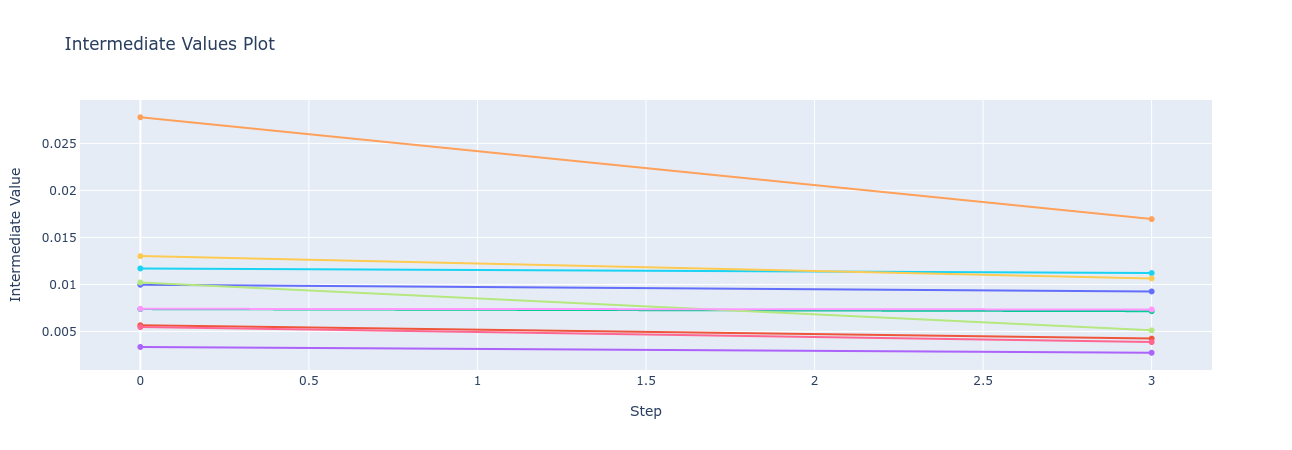

In [151]:
import joblib
joblib.dump(study, 'study2.pkl')
study2 = joblib.load('study2.pkl')
print('Best trial until now:')
print(' Value: ', study2.best_trial.value)
print(' Params: ')
for key, value in study2.best_trial.params.items():
    print(f'    {key}: {value}')

Best trial until now:
 Value:  0.00039813510886080674
 Params: 
    learning_rate: 0.0020574791074529975
    dropout_rate: 0
    latent_size: 64
    frequency_bins: 30
    time_steps: 20
    hidden_layers: 1
    l2: 1.0494963315643493e-06
